In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn # ignore warning (from sklearn and seaborn)


from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x)) #Limiting floats output to 3 decimal points

In [4]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [5]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train_raw = train['time']
y_train = y_train_raw.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['time'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (500, 14)


In [6]:
all_data.drop(['l1_ratio', 'alpha', 'random_state', 'n_clusters_per_class', 'n_informative', 'flip_y', 'scale'], axis=1, inplace=True)
all_data['n_classes'].replace(2,1,inplace=True)
all_data['n_jobs'].replace(-1, 16, inplace=True)
all_data['penalty'] = all_data['penalty'].map({'none': 1, 'l2': 2, 'l1': 3, 'elasticnet': 4})

In [7]:
# a few ways to combine the features, only e_factor is used in the final submission
all_data['factor'] = all_data['n_classes'] * all_data['max_iter'] * all_data['n_features'] * all_data['n_samples']
all_data['s_factor'] = all_data['max_iter'] * all_data['n_features'] * all_data['n_samples']
all_data['e_factor'] = (np.ceil(all_data['n_classes'] / all_data['n_jobs'])) * all_data['max_iter'] * all_data['n_features'] * all_data['n_samples']

In [8]:
# scale the data. It is not necessary for linear regression, but I have this code here when trying something else
scaled_all = all_data.copy()
for column in scaled_all.columns:
    if column in ['id', 'n_classes', 'n_jobs']:
        continue
    scaled_all[column] = scaled_all[column] / max(scaled_all[column])
train = scaled_all[:ntrain]
test = scaled_all[ntrain:]

In [9]:
train.head()

,id,max_iter,n_classes,n_features,n_jobs,n_samples,penalty,factor,s_factor,e_factor
0,0,0.4178,4,0.1641,16,0.5464,0.2500,0.0249,0.0623,0.0134
1,1,0.5792,4,0.1872,1,0.3964,0.7500,0.0286,0.0714,0.0615
2,2,0.5892,1,0.6011,2,0.2148,0.2500,0.0126,0.1264,0.0272
3,3,0.8307,6,0.1570,4,0.4400,0.2500,0.0573,0.0954,0.0411
4,4,0.1673,8,0.3231,2,0.1084,1.0000,0.0078,0.0097,0.0084


In [10]:
# simple wrapper of the matplotlib plot function, also plot the fitted straight line
def sc_plot(x, y, intercept=None, slope=None):
    fig, ax = plt.subplots()
    ax.scatter(x = x, y = y)
    plt.ylabel('y', fontsize=13)
    plt.xlabel('x', fontsize=13)
    if intercept is not None and slope is not None:
        x_vals = np.array(ax.get_xlim())
        y_vals = intercept + slope * x_vals
        plt.plot(x_vals, y_vals, '--')
    plt.show()

# this function loops over each type of penalty and make a plot of each type (i.e. 4 plots in total)
def plot_df(df, y_name='factor', line=True):
    for pen in [0.25, 0.5, 0.75, 1]:
        current_df = df.loc[(df['penalty'] == pen)]
        slope, intercept, r_value, p_value, std_err = stats.linregress(current_df[y_name],current_df['time'])
        print("pen: ", pen)
        print("slope: %s, intercept: %s, std_err: %s" % (slope, intercept, std_err))
        if line:
            sc_plot(current_df[y_name], current_df['time'], intercept, slope)
        else:
            sc_plot(current_df[y_name], current_df['time'])

In [11]:
# split the data according to its n_classes and n_jobs
def split_df(df, classes, jobs):
    all_df = []
    for n_class in classes:
        for job in jobs:
            all_df.append(df.loc[(df['n_classes'] == n_class) & (df['n_jobs'] == job)])
    return pd.concat(all_df)

In [12]:
train_l = train.join(y_train_raw, how='inner')

pen:  0.25
slope: 13.755378294640709, intercept: 0.15847634111912434, std_err: 0.4394877182277847


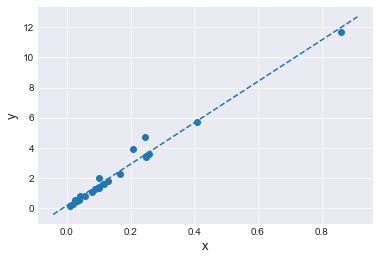

pen:  0.5
slope: 14.003737761095834, intercept: 0.002895519110340583, std_err: 0.10064289633405879


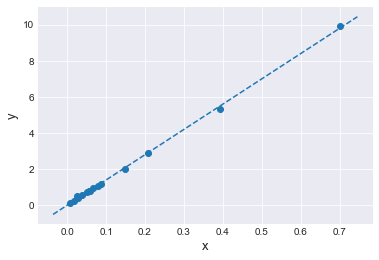

pen:  0.75
slope: 60.875252278847846, intercept: 0.31078319843459745, std_err: 0.5932003524426641


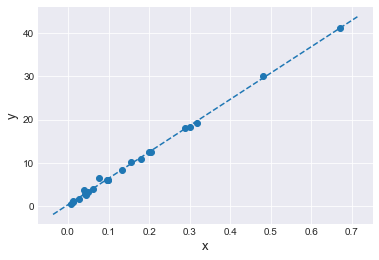

pen:  1
slope: 77.44640052675192, intercept: -0.04530154631619254, std_err: 0.7432279557806906


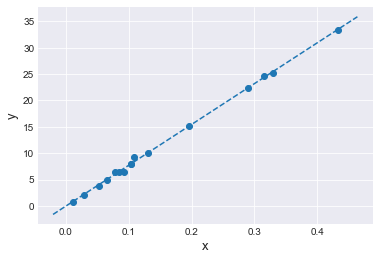

In [13]:
# all n_classes with n_jobs = 1, data for each type of penalty are plotted separately
a = split_df(train_l, [1,3,4,5,6,7,8,9,10], [1])
plot_df(a, 'e_factor')

pen:  0.25
slope: 14.839218380730195, intercept: 0.032444754002760146, std_err: 0.3279783003810308


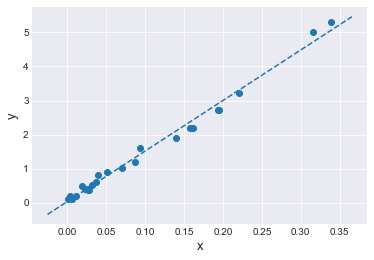

pen:  0.5
slope: 13.587405066602727, intercept: 0.13446891312241216, std_err: 0.4764941205299353


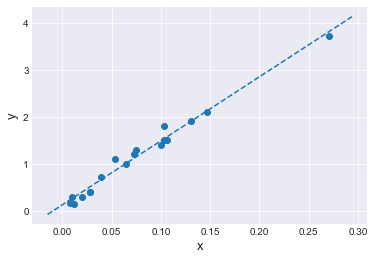

pen:  0.75
slope: 67.36039629758707, intercept: 0.2245210993168758, std_err: 1.212602586313716


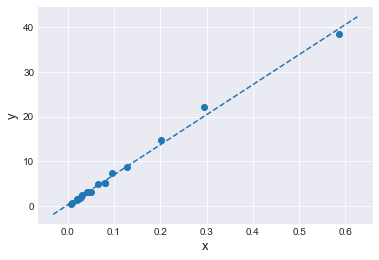

pen:  1
slope: 71.74768682540821, intercept: 0.6304007152855879, std_err: 1.7752820460400929


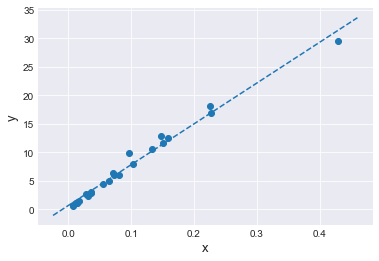

In [14]:
a = split_df(train_l, [1,3,4,5,6,7,8,9,10], [2])
plot_df(a, 'e_factor')

pen:  0.25
slope: 14.945233540245455, intercept: 0.06451574207144695, std_err: 0.4158466402979064


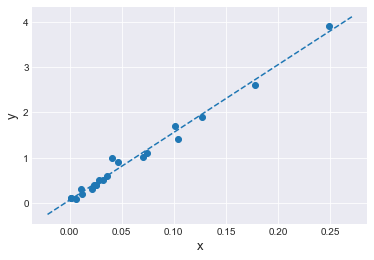

pen:  0.5
slope: 14.154443632276275, intercept: 0.05909980653669822, std_err: 0.18837913444641463


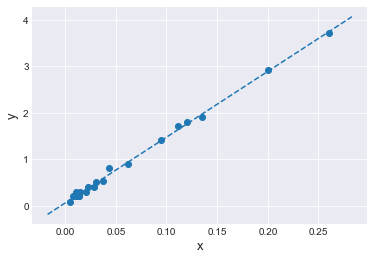

pen:  0.75
slope: 64.13907711158706, intercept: 0.1948619912555003, std_err: 1.7035736885142532


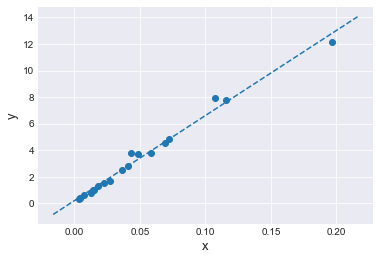

pen:  1
slope: 76.6974156019296, intercept: 0.16260069412312417, std_err: 1.9269318355936305


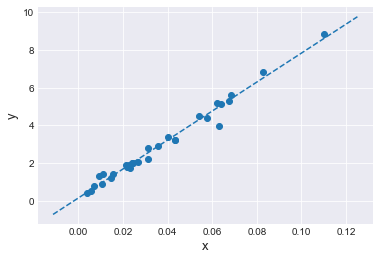

In [15]:
a = split_df(train_l, [1,3,4,5,6,7,8,9,10], [4])
plot_df(a, 'e_factor')

pen:  0.25
slope: 13.907031724395464, intercept: 0.13580408367885044, std_err: 0.8508736373154676


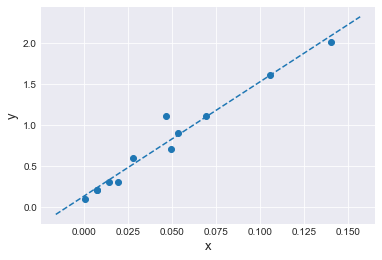

pen:  0.5
slope: 14.737119340950946, intercept: 0.12207038936420561, std_err: 0.6132859216042938


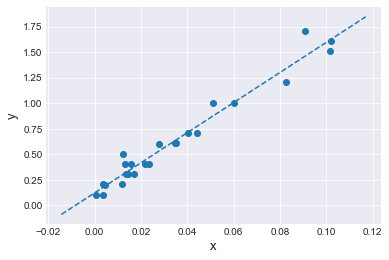

pen:  0.75
slope: 59.50720976057784, intercept: 0.3180845182910197, std_err: 2.8144504654788873


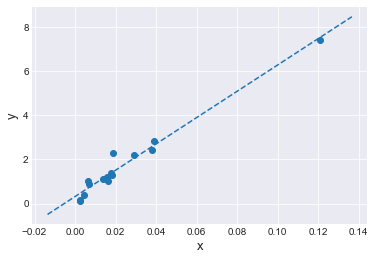

pen:  1
slope: 79.76313028707125, intercept: 0.3151688258782257, std_err: 2.805625141514075


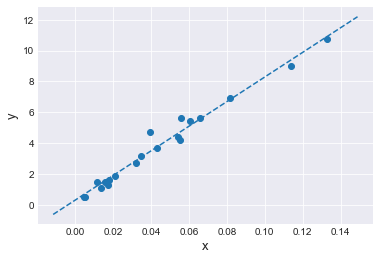

In [16]:
a = split_df(train_l, [1,3,4,5,6,7,8,9,10], [8])
plot_df(a, 'e_factor')

pen:  0.25
slope: 14.177483661919894, intercept: 0.11926013195140328, std_err: 0.792536826808056


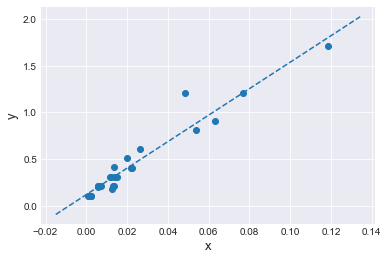

pen:  0.5
slope: 14.737830524389755, intercept: 0.1318290891458277, std_err: 0.7811026214978211


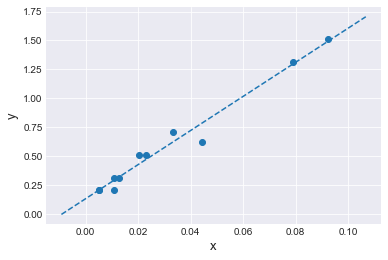

pen:  0.75
slope: 64.3747575980325, intercept: 0.21727450958533145, std_err: 2.4907133068828644


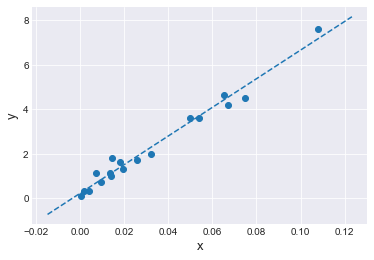

pen:  1
slope: 80.01657252935343, intercept: 0.22160940906170756, std_err: 2.395616804722579


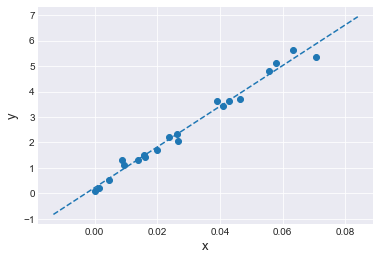

In [17]:
a = split_df(train_l, [1,3,4,5,6,7,8,9,10], [16])
plot_df(a, 'e_factor')

In [18]:
# train data and test data are divided into 5*4 = 20 parts and each part is treated separately
pred_results = []
for job in [1,2,4,8,16]:
    for pen in [0.25, 0.5, 0.75, 1]:
        # training
        job_n = train.loc[train['n_jobs'] == job]
        job_n_p_n = job_n.loc[job_n['penalty'] == pen]
        job_n_p_n_t = job_n_p_n.join(y_train_raw, how='inner')
        factors_to_fit = np.reshape(job_n_p_n_t['e_factor'].values, (-1, 1))
        reg = LinearRegression().fit(factors_to_fit, job_n_p_n_t['time'])
        train_pred = reg.predict(factors_to_fit)
        print(mean_squared_error(train_pred, job_n_p_n_t['time']))
        # prediction
        test_job_n = test.loc[test['n_jobs'] == job]
        test_job_n_p_n = test_job_n.loc[test_job_n['penalty'] == pen]
        factors_to_predict = np.reshape(test_job_n_p_n['e_factor'].values, (-1, 1))
        pred = reg.predict(factors_to_predict)
        # append both prediction results and id of test data to a list
        pred_results.append(np.array([test_job_n_p_n['id'].values, pred]))

0.12785615439841957
0.004230270668659695
0.1915430077371901
0.1115180336002552
0.02215288458340031
0.014498322644076014
0.4573536529560453
0.627823939034192
0.01258034729214097
0.0030428656284337318
0.11531521514229862
0.06897552346112273
0.0121116182673813
0.008050646643406947
0.08413252531752326
0.1645948499265288
0.0107593233835565
0.004466343548454362
0.0877279539547538
0.045871240362965394


In [19]:
# concatentate all prediction results
pred_array = np.array([[], []])
for arr in pred_results:
    pred_array = np.concatenate((pred_array, arr), axis=1)
print(pred_array.shape)

(2, 100)


In [20]:
# output
results = pd.DataFrame(data=pred_array.transpose(), columns=['id', 'time'])
sorted_results = results.sort_values('id')
sorted_results['id'] = pd.to_numeric(sorted_results['id'], downcast='integer')
sorted_results.to_csv('lin_reg_e_factor_no_cor_after_comp.csv', index=False)